# INFO 2950 Final Project

In [51]:
import pandas as pd
import seaborn

In [52]:
%load_ext sql

%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False

%sql duckdb:///:memory:

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


Reserach Question: Explore the change in the distribution of biased motivation of hate crime from 2016-2020, and the effect of Covid in between.

In [53]:
# Import 2019 Table 1
table1_19 = pd.read_csv('./Data_2019/CSV_files_2019/Incidents_Offenses_Victims_and_Known_Offenders_by_Bias_Motivation_2019.csv', thousands=',')
table1_19.head()

,Bias_motivation,Incidents,Offenses,Victims1,Known_offenders2
0,Total,7314,8559,8812,6406
1,Single-Bias Incidents,7103,8302,8552,6268
2,Race/Ethnicity/Ancestry:,3963,4784,4930,3550
3,Anti-White,666,755,775,645
4,Anti-Black or African American,1930,2314,2391,1682


In [54]:
# Import 2019 Table 4
table4_19 = pd.read_csv('./Data_2019/CSV_files_2019/Offenses_Offense_Type_by_Bias_Motivation_2019 v2.csv', thousands=',')
table4_19.head()

,Bias_motivation,Total_offenses,Murder_and_nonnegligent_manslaughter,Rape,Aggravated_assault,Simple_assault,Intimidation,"Human_Trafficking,_Commercial_Sex_Acts",Other_crimes_against_persons,Robbery,Burglary,Larceny_theft,Motor_vehicle_theft,Arson,Destruction_damage_vandalism,Other_crimes_against_properties,Crimes_against_society
0,Total,8559,51,30,1158,2023,2206,3,41,125,114,284,19,60,2152,57,236
1,Single-Bias Incidents,8302,51,30,1139,1976,2134,3,41,125,109,282,19,55,2050,57,231
2,Race/Ethnicity/Ancestry:,4784,31,12,726,1225,1385,0,13,62,46,149,13,16,901,35,170
3,Anti-White,755,0,6,108,240,143,0,3,16,10,56,4,1,72,15,81
4,Anti-Black or African American,2314,1,2,344,546,797,0,8,13,17,19,3,9,516,5,34


In [55]:
%sql offense_type << SELECT * FROM table1_19 FULL OUTER JOIN table4_19 ON table1_19.Offenses = table4_19.Total_Offenses

offense_type = offense_type.loc[:,~offense_type.columns.duplicated()]
offense_type = offense_type.drop(['Total_offenses'],axis=1)
offense_type.head()

Returning data to local variable offense_type


,Bias_motivation,Incidents,Offenses,Victims1,Known_offenders2,Murder_and_nonnegligent_manslaughter,Rape,Aggravated_assault,Simple_assault,Intimidation,"Human_Trafficking,_Commercial_Sex_Acts",Other_crimes_against_persons,Robbery,Burglary,Larceny_theft,Motor_vehicle_theft,Arson,Destruction_damage_vandalism,Other_crimes_against_properties,Crimes_against_society
0,Total,7314,8559,8812,6406,51,30,1158,2023,2206,3,41,125,114,284,19,60,2152,57,236
1,Single-Bias Incidents,7103,8302,8552,6268,51,30,1139,1976,2134,3,41,125,109,282,19,55,2050,57,231
2,Race/Ethnicity/Ancestry:,3963,4784,4930,3550,31,12,726,1225,1385,0,13,62,46,149,13,16,901,35,170
3,Anti-White,666,755,775,645,0,6,108,240,143,0,3,16,10,56,4,1,72,15,81
4,Anti-Black or African American,1930,2314,2391,1682,1,2,344,546,797,0,8,13,17,19,3,9,516,5,34


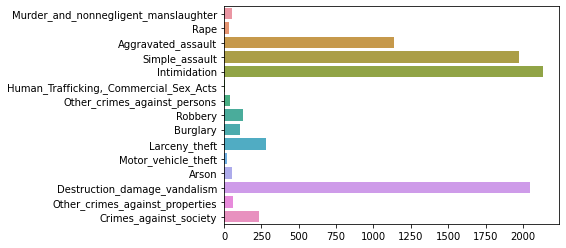

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns

# take bm Race/Ethnicity/Ancestry 2019 as an example
t4_19 = table4_19.drop(['Bias_motivation', 'Total_offenses'],axis=1)
sns.barplot(data=t4_19.iloc[1:2], orient = 'h')
plt.show()

In [57]:
# import math
# # t4_19 = table4_19.drop(['Bias_motivation', 'Total_offenses'],axis=1)

# # take bm Race/Ethnicity/Ancestry 2019 as an example
# data = t4_19.iloc[2,:].to_numpy().tolist()
# labels = t4_19.columns.to_list()
# colors = sns.color_palette('pastel')[0:15]
# fig, ax = plt.subplots()

# # plt.pie(data, labels = labels, colors = colors, autopct='%.1f%%')
# l = ax.pie(data, autopct='%.1f%%', startangle=-90)

# for label, t in zip(labels, l[1]):
#     x, y = t.get_position()
#     angle = int(math.degrees(math.atan2(y, x)))
#     ha = "left"

#     if x<0:
#         angle -= 180
#         ha = "right"

#     plt.annotate(label, xy=(x,y), rotation=angle, ha=ha, va="center", rotation_mode="anchor", size=8)

# plt.show()


In [58]:
# Import 2016 Table 4
table4_16 = pd.read_csv('./Data_2016/CSV_files_2016/Table_4_Offenses_Offense_Type_by_Bias_Motivation_2016 revised.csv', thousands=',')
table4_16.head()


,Bias_motivation,Total_offenses,Murder_and_nonnegligent_manslaughter,Rape,Aggravated_assault,Simple_assault,Intimidation,Other_crime_against_persons,Robbery,Burglary,Larceny_theft,Motor_vehicle_theft,Arson,Destruction_damage_vandalism,Other_crimes_against_property,Crime_against_societies
0,Total,7321,9,24,873,1687,2109,18,134,123,231,20,39,1913,59,82
1,Single-Bias Incidents,7227,9,23,866,1677,2074,17,131,122,227,20,38,1882,59,82
2,Race/Ethnicity/Ancestry:,4229,7,10,548,1002,1320,5,71,75,149,14,13,916,46,53
3,Anti-White,876,5,5,120,241,188,2,30,22,78,6,2,122,24,31
4,Anti-Black or African American,2122,2,2,273,455,782,2,14,17,14,2,7,537,5,10


In [59]:
# Import 2017 Table 4
table4_17 = pd.read_csv('./Data_2017/CSV_files_2017/Table_4_Offenses_Offense_Type_by_Bias_Motivation_2017 revised.csv', thousands=',')
table4_17.head()


,Bias_motivation,Total_offenses,Murder_and_nonnegligent_manslaughter,Rape,Aggravated_assault,Simple_assault,Intimidation,"Human_Trafficking,_Commercial_Sex_Acts",Other_crime_against_persons,Robbery,Burglary,Larceny_theft,Motor_vehicle_theft,Arson,Destruction_damage_vandalism,Other_crimes_against_property,Crimes_against_society
0,Total,8437,15,23,990,1745,2283,1,27,157,145,326,41,42,2325,79,238
1,Single-Bias Incidents,8126,15,23,975,1623,2156,1,27,157,140,323,41,41,2291,79,234
2,Race/Ethnicity/Ancestry:,4832,11,8,638,965,1442,1,15,84,83,208,35,24,1111,40,167
3,Anti-White,844,5,2,105,203,171,0,7,22,24,92,14,3,113,20,63
4,Anti-Black or African American,2358,5,1,326,454,820,0,2,19,29,17,2,15,640,6,22


In [60]:
# Import 2018 Table 4
table4_18 = pd.read_csv('./Data_2018/CSV_files_2018/Table_4_Offenses_Offense_Type_by_Bias_Motivation_2018 revised.csv', thousands=',')
table4_18.head()

,Bias_motivation,Total_offenses,Murder_and_nonnegligent_manslaughter,Rape,Aggravated_assault,Simple_assault,Intimidation,Other_crime_against_persons,Robbery,Burglary,Larceny_theft,Motor_vehicle_theft,Arson,Destruction_damage_vandalism,Other_crimes_against_property,Crime_against_societies
0,Total,8496,24,22,1026,1895.0,2560,39,132,131,330,42,43,1876,87,289
1,Single-Bias Incidents,8327,24,22,1017,1882.0,2468,39,131,129,325,42,43,1830,86,289
2,Race/Ethnicity/Ancestry:,4954,8,9,659,1121.0,1627,21,68,76,195,26,16,854,50,224
3,Anti-White,1001,3,6,114,250.0,289,9,15,24,79,8,1,91,20,92
4,Anti-Black or African American,2325,4,2,323,486.0,908,2,14,24,22,3,10,474,3,50


In [61]:
# Simplify Table 4

%sql table4_16_type << SELECT Bias_motivation, Total_offenses AS Total_offenses_16 FROM table4_16 WHERE Bias_motivation IN('Race/Ethnicity/Ancestry:', 'Religion:', 'Sexual Orientation:', 'Disability:', 'Gender:', 'Gender Identity:', 'Multiple-Bias Incidents')

%sql table4_17_type << SELECT Bias_motivation, Total_offenses AS Total_offenses_17 FROM table4_17 WHERE Bias_motivation IN('Race/Ethnicity/Ancestry:', 'Religion:', 'Sexual Orientation:', 'Disability:', 'Gender:', 'Gender Identity:', 'Multiple-Bias Incidents')

%sql table4_18_type << SELECT Bias_motivation, Total_offenses AS Total_offenses_18 FROM table4_18 WHERE Bias_motivation IN('Race/Ethnicity/Ancestry:', 'Religion:', 'Sexual Orientation:', 'Disability:', 'Gender:', 'Gender Identity:', 'Multiple-Bias Incidents')

%sql table4_19_type << SELECT Bias_motivation, Total_offenses AS Total_offenses_19 FROM table4_19 WHERE Bias_motivation IN('Race/Ethnicity/Ancestry:', 'Religion:', 'Sexual Orientation:', 'Disability:', 'Gender:', 'Gender Identity:', 'Multiple-Bias Incidents')


Returning data to local variable table4_16_type
Returning data to local variable table4_17_type
Returning data to local variable table4_18_type
Returning data to local variable table4_19_type


Bias_motivation,Race/Ethnicity/Ancestry:,Religion:,Sexual Orientation:,Disability:,Gender:,Gender Identity:,Multiple-Bias Incidents
Total_offenses_16,4229,1538,1218,76,36,130,94
Total_offenses_17,4832,1679,1303,128,53,131,311
Total_offenses_18,4954,1550,1404,177,58,184,169
Total_offenses_19,4784,1650,1395,169,80,224,257


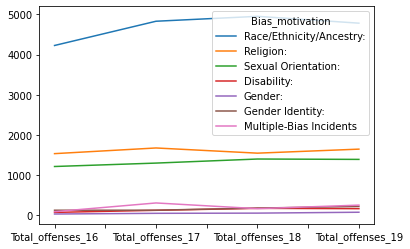

In [62]:
# Combine Table 4 from 2016-2019
combined_table4 = pd.concat([table4_16_type, table4_17_type, table4_18_type, table4_19_type], axis=1)
combined_table4 = combined_table4.loc[:,~combined_table4.columns.duplicated()].copy()

combined_table4 = combined_table4.T
fheader = combined_table4.iloc[0]
combined_table4 = combined_table4[1:]
combined_table4.columns = fheader
display(combined_table4)

combined_table4.plot()
plt.show()